- tenemos que considerar que este video sera para comparar la diferencia entre usar 2 datasets con diferente tamaño y entender realmente como evitar el overfitting, practicamente veremos de forma practica lo que se hablo en el video de como evitar el overfitting de dotcsv. 
- compararemos el ejercicio anterior con este, usaremos la misma arquitectura de NN solo cambiaremos el dataset
- en el notebook anterior clasificamos humanos y caballos: 
  - dataset:
    - 628 imagenes de cada categoria
    - shape de cada muestra (300, 300, 3)
  - modelo: 
    - mejores metricas epoca:12 loss: 0.0016 - accuracy: 1.0000 - val_loss: 2.7613 - val_accuracy: 0.8203
    - Total params: 40,165,409

- en este notebook clasificaremos a perros y gatos: 
  - dataset:
    - 11250 imagenes de cada categoria
    - shape de cada muestra (150, 150, 3)
  - modelo: 
    - mejores metricas epoca:8 loss: 0.3042 - acc: 0.8703 - val_loss: 0.3851 - val_acc: 0.8260
    - Total params: 9,494,561 

- aprenderemos 
- aprenderemos a hacer un split de data, desde 0:
  0. partiremos de 2 carpetas con imagenes de 2 categorias
  1. crearemos una carpeta para cada categoria de train y test 
  2. haremos sanity check: revisaremos que ninguna imagen venga dañada o vacia 
  3. revolveremos el dataset antes del split, para evitar que los datos tengan alguna secuencia que afecte la fase de evaluacion 
  4. haremos el split o hold out, para poder evaluar el modelo con data nunca vista por el 
  revisar funcion: def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):

- aprenderas que se puede entrenar y evaluar el modelo en un solo paso y ahora si entenderas que la funcion model.fit regresa las metricas de evaluacion y entrenamiento y aprenderas a usarlas para graficar el accuracy y la loss en entrenamiento y evaluacion.

```
history = model.fit(train_generator, epochs=15, steps_per_epoch=90,
                    validation_data=validation_generator, validation_steps=6) 
# los steps indicaran cada cuantas cuantos datos de las metricas se recogeran cada epoca, para despues ser ploteados 
```
- aprenderas que la metrica de accuracy de evaluacion es el mas importante ya que nos dice relamente la presicion del modelo con informacion del mundo real, nunca antes visto. 
- al observar las graficas que comparen el accuracy de train vs evaluation entenderas lo que significa el overfitting. lo importante es punto de infleccion sucede aproximadamente a las 6 epocasa partir del cual  no tiene sentido seguir entrenando por mas tiempo para mejorar las metricas de valuacion del modelo.
- si queremos mejorar el accuracy de evaluacion podemos hacer lo siguiente 
  - aumentar el dataset, creando ampliacion de las imagenes (lo mas adecuado)
  - modificar la arquitectura del modelo
  - modificar la loss o optimizer (ya se tiene establecido que funciones trabajan mejor en tareas especificas)
- aprenderemos a cargar archivo de nuestra pc  a una variable del codigo. 

```
# esta linea te permite cargar un archivo desde tu pc a colab se guardaran en la carpeta de /content/ de la maquina 
uploaded = files.upload()

for fn in uploaded.keys():  # pudimos haber cargado varios archivos atras y con esto sacariamos cada archivo uno por uno

```




nombre original    
Copia de Lab6-Cats-v-Dogs.ipynb

## Training with a Larger Dataset - Cats and Dogs

In the previous lab you trained a classifier with a horses-v-humans dataset. **You saw that despite getting great training results, when you tried to do classification with real images, there were many errors, due primarily to overfitting** -- where the network  does very well with data that it has previously seen, but poorly with data it hasn't!

In this lab you'll look at a real, and very large dataset, and see the impact this has to avoid overfitting.

In [ ]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [ ]:
# If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL to the dataset

# Note: This is a very large dataset and will take time to download

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


--2022-02-01 19:55:59--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.198.170.191, 2600:1409:9800:686::e59, 2600:1409:9800:693::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.198.170.191|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M  68.9MB/s    in 11s     

2022-02-01 19:56:10 (73.1 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



analizando el dataset
vemos que el dataset esta compuesto de dos carpetas con 12501 imagenes de perros y gatos reales en formato jpg  

12501
12501
8180.jpg


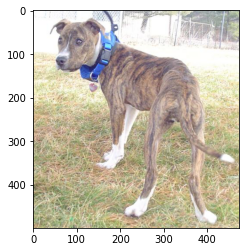

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))
print(os.listdir('/tmp/PetImages/Dog/')[1])

img_perro = '/tmp/PetImages/Dog/' + os.listdir('/tmp/PetImages/Dog/')[0]

img = mpimg.imread(img_perro)
plt.imshow(img)
# Expected Output:
# 12501
# 12501

In [ ]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [ ]:
print(CAT_SOURCE_DIR + os.listdir(CAT_SOURCE_DIR)[0])
print(os.path.getsize(CAT_SOURCE_DIR + os.listdir(CAT_SOURCE_DIR)[0]))

/tmp/PetImages/Cat/6421.jpg
7238


# preprocesamiento del dataset manual, sanitizacion de los datos
## comprobamos que cada imagen no sea una imagen dañada sin peso 
os.path.getsize() method in Python is used to check the size of specified path. It returns the size of specified path in bytes. The method raise OSError if the file does not exist or is somehow inaccessible.

In [ ]:
# creamos una funcion para partir el dataset en training y test 
# split_data(directorio del DS, directorio trainig destino, ´´´test, particion de la data [0-1] )
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    # este bucle creara una lista con el nombre de los archivos omitiendo aquellos archivos que no tengan peso 
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")
    ## print(files[0]) = 6421.jpg
    # calculamos el tamaño de datos total para cada particion 
    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)

    # se revolveran los datos de la lista files. 
    # el metodo sample toma una muestra aleatoria de tamaño len(files), de la lista files
    shuffled_set = random.sample(files, len(files))
    # ya revuelto, se creara una lista con las direcciones de cada imagen para cada particion
    training_set = shuffled_set[0:training_length]
    # esto indica que se tomaran desde el ultimo archivo en reversa hasta contar testing lenght 
    testing_set = shuffled_set[-testing_length:]
    ## print("this file ", SOURCE + filename[0]) = this file  /tmp/PetImages/Cat/1
    ## print("destination ", TRAINING + filename[0]) = destination  /tmp/cats-v-dogs/training/cats/1
    # copiara los archivos a carpetas de training y test 
    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

666.jpg is zero length, so ignoring.
6421.jpg
this file  /tmp/PetImages/Cat/1
destination  /tmp/cats-v-dogs/training/cats/1
11702.jpg is zero length, so ignoring.
6421.jpg
this file  /tmp/PetImages/Dog/1
destination  /tmp/cats-v-dogs/training/dogs/1


In [ ]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))
print(os.path.getsize('/tmp/cats-v-dogs/testing/dogs/'))
# Expected output:
# 11250
# 11250
# 1250
# 1250

11250
11250
1250
1250
36864


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 17, 17, 64)      

In [ ]:

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=250,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=250,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

# Expected Output:
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

Found 22499 images belonging to 2 classes.
Found 2499 images belonging to 2 classes.


In [ ]:
# Note that this may take some time.
history = model.fit(train_generator, epochs=15, steps_per_epoch=90,
                    validation_data=validation_generator, validation_steps=6) # los steps indicaran cada cuantas cuantos datos de las metricas se recogeran cada epoca, para despues ser ploteados 

Epoch 1/15
51/90 [================>.............] - ETA: 26s - loss: 0.9228 - acc: 0.5467

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

90/90 [==============================] - 79s 753ms/step - loss: 0.8080 - acc: 0.5828 - val_loss: 0.6463 - val_acc: 0.6407
Epoch 2/15
90/90 [==============================] - 67s 740ms/step - loss: 0.5872 - acc: 0.6911 - val_loss: 0.5818 - val_acc: 0.6753
Epoch 3/15
90/90 [==============================] - 66s 738ms/step - loss: 0.5195 - acc: 0.7422 - val_loss: 0.5404 - val_acc: 0.7167
Epoch 4/15
90/90 [==============================] - 68s 750ms/step - loss: 0.4755 - acc: 0.7733 - val_loss: 0.4583 - val_acc: 0.7807
Epoch 5/15
90/90 [==============================] - 67s 744ms/step - loss: 0.4241 - acc: 0.8054 - val_loss: 0.4102 - val_acc: 0.8040
Epoch 6/15
90/90 [==============================] - 67s 740ms/step - loss: 0.3926 - acc: 0.8236 - val_loss: 0.3991 - val_acc: 0.8167
Epoch 7/15
90/90 [==============================] - 67s 738ms/step - loss: 0.3506 - acc: 0.8431 - val_loss: 0.4023 - val_acc: 0.8107
Epoch 8/15
90/90 [==============================] - 67s 738ms/step - loss: 0.304

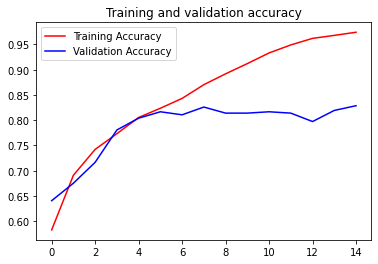

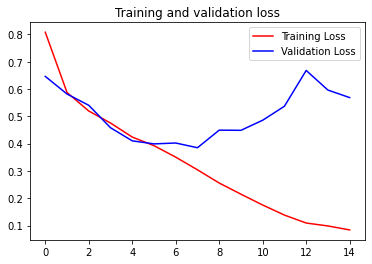

In [ ]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc'] # accuracy de training 
val_acc=history.history['val_acc'] # accuracy de validation 
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label ="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label ="Validation Accuracy")
plt.legend(loc = 'upper left')
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.title('Training and validation loss')
plt.legend(loc = 'upper right')

# lo enbellecimos con: https://aprendeconalf.es/docencia/python/manual/matplotlib/

# Desired output. Charts with training and validation metrics. No crash :)

# Interpretando las graficas del overfitting 
como vemos en ambas gaficas hay un punto en el que el accuracy y loss para la validacion dejan de mejorar, sin importar que sigamos entrenando por mas tiempo el modelo. aunque el accuaracy y loss siguen mejorando durante el entrenamiento, las mismas metricas para evaluacion no, y estas son las que realmente nos interesan, ya que asi es como probaremos nuestro modelo con imagenes nunca antes vistas.  
este **punto de infleccion sucede aproximadamente a las 6 epocas, y como conclucion tenemos que no tiene sentido seguir entrenando por mas tiempo para mejorar las metricas del modelo**. temos varias opciones:
- aumentar el dataset, creando ampliacion de las imagenes (lo mas adecuado)
- modificar la arquitectura del modelo 
- modificar la loss o optimizer (ya se tiene establecido que funciones trabajan mejor en tareas especificas)
# conclucion 
una CNN con 8 capas y un Total params: 9,494,561, entrenada con 22,500 imagenes de 2 categorias(11250por categoria), y con una grafica (Tesla T4, 8984MiB / 15109MiB ), con la cual tardo 18 min de entrenamiento y evaluacion. Las mejores metricas durante el entrenamiento fueron (completando las 15 epocas):     
- loss: 0.0841 - acc: 0.9741   
y durante la evaluacion, antes del overffiting(epoca 7):    
- val_loss: 0.4023 - val_acc: 0.8107


In [ ]:
!nvidia-smi

Tue Feb  1 21:44:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    26W /  70W |   8984MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Here's a codeblock just for fun. You should be able to upload an image here 
# and have it classified without crashing
import numpy as np
from google.colab import files
from keras.preprocessing import image

# esta linea te permite cargar un archivo desde tu pc a colab se guardaran en la carpeta de /content/ de la maquina 
uploaded = files.upload()

for fn in uploaded.keys():  # pudimos haber cargado varios archivos atras y con esto sacariamos cada archivo uno por uno
 
  # predicting images
  path = '/content/' + fn
  # las siguiente dos lineas son un equivalente a image.img_to_array(image.load_img(img, target_size = (299, 299)))
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  # print(x.shape) = (150, 150, 3)
  # agregamos una dimecion al inicio ya que el modelo recibe lotes de imagenes 
  # el equivalente el el colab de adversarialNN x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
  x = np.expand_dims(x, axis=0)
  # print(x.shape) = (1, 150, 150, 3)

  # la lina de abajo sirve para apilar mas de una foto y crear un lote 
  images = np.vstack([x])
  # print(images.shape) = (1, 150, 150, 3)
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving perrito.jpg to perrito (1).jpg
[1.]
perrito.jpg is a dog


In [ ]:
# Before running the next exercise, run the following cell to terminate the kernel and free memory resources:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)